# Fine-Tuning T5 for Idiom Paraphrasing
This code is an adapted version of the code found in:
https://shivanandroy.com/fine-tune-t5-transformer-with-pytorch/

#0. Installs, Imports, Setup


##0.1 Import Libraries & Packages

In [ ]:
!pip install sentencepiece -q
!pip install transformers -q
!pip install torch -q
!pip install rich[jupyter] -q

!pip install -U nltk -q
!pip install datasets -q


     |████████████████████████████████| 1.2 MB 10.0 MB/s 
     |████████████████████████████████| 4.2 MB 7.1 MB/s 
     |████████████████████████████████| 596 kB 64.5 MB/s 
     |████████████████████████████████| 6.6 MB 52.6 MB/s 
     |████████████████████████████████| 86 kB 4.9 MB/s 
     |████████████████████████████████| 232 kB 8.7 MB/s 
     |████████████████████████████████| 51 kB 8.0 MB/s 
     |████████████████████████████████| 1.5 MB 7.6 MB/s 
     |████████████████████████████████| 749 kB 54.1 MB/s 
     |████████████████████████████████| 346 kB 3.9 MB/s 
     |████████████████████████████████| 1.1 MB 10.7 MB/s 
     |████████████████████████████████| 212 kB 25.8 MB/s 
     |████████████████████████████████| 86 kB 6.3 MB/s 
     |████████████████████████████████| 140 kB 30.5 MB/s 
     |████████████████████████████████| 127 kB 34.3 MB/s 
     |████████████████████████████████| 271 kB 37.2 MB/s 
     |████████████████████████████████| 144 kB 41.5 MB/s 
     |██████████████████

In [ ]:
# Drive
from google.colab import drive

# Plots
import IPython
import IPython.display
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

# Util
import os
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)

# ML
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

# Importing the T5 modules from huggingface/transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration

# rich: for a better display on terminal
from rich.table import Column, Table
from rich.text import Text
from rich import box
from rich.console import Console

# define a rich console logger
console = Console(record=True)

# Evaluation
from datasets import load_metric
meteor = load_metric("meteor")

# Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


<Figure size 864x432 with 0 Axes>

##0.2. Import Data

Either upload the data to the shared Google Drive and use this to download, or upload it directly yourself (whatever is easier)

In [ ]:
drive.mount('/content/drive')


Mounted at /content/drive


##0.3 Setup functions & classes

###0.3.1 FUNC: display_df

In [ ]:
# to display dataframe in ASCII format
def display_df(df):
    """display dataframe in ASCII format"""

    console = Console()
    table = Table(
        Column("source_text", justify="center"),
        Column("target_text", justify="center"),
        title="Sample Data",
        pad_edge=False,
        box=box.ASCII,
    )

    for i, row in enumerate(df.values.tolist()):
        table.add_row(row[0], row[1])

    console.print(table)

###0.3.2 CLASS: DataSet

A Dataset class for reading and loading the dataset into the dataloader, and then feed it into the neural network for fine-tuning the model.

In [ ]:
class DataSet(Dataset):
    """
    Creating a dataset class for reading the dataset and
    loading it into the dataloader, to pass it to the
    neural network for finetuning the model

    """

    def __init__(
        self, dataframe, tokenizer, source_len, target_len, source_text, target_text
    ):
        """
        Initializes a Dataset class

        Args:
            dataframe (pandas.DataFrame): Input dataframe
            tokenizer (transformers.tokenizer): Transformers tokenizer
            source_len (int): Max length of source text
            target_len (int): Max length of target text
            source_text (str): column name of source text
            target_text (str): column name of target text
        """
        self.tokenizer = tokenizer
        self.data = dataframe
        self.source_len = source_len
        self.summ_len = target_len
        self.target_text = self.data[target_text]
        self.source_text = self.data[source_text]

    def __len__(self):
        """returns the length of dataframe"""

        return len(self.target_text)

    def __getitem__(self, index):
        """return the input ids, attention masks and target ids"""

        source_text = str(self.source_text[index])
        target_text = str(self.target_text[index])

        # cleaning data so as to ensure data is in string type
        source_text = " ".join(source_text.split())
        target_text = " ".join(target_text.split())

        source = self.tokenizer.batch_encode_plus(
            [source_text],
            max_length=self.source_len,
            pad_to_max_length=True,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        target = self.tokenizer.batch_encode_plus(
            [target_text],
            max_length=self.summ_len,
            pad_to_max_length=True,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )

        source_ids = source["input_ids"].squeeze()
        source_mask = source["attention_mask"].squeeze()
        target_ids = target["input_ids"].squeeze()
        target_mask = target["attention_mask"].squeeze()

        return {
            "source_ids": source_ids.to(dtype=torch.long),
            "source_mask": source_mask.to(dtype=torch.long),
            "target_ids": target_ids.to(dtype=torch.long),
            "target_ids_y": target_ids.to(dtype=torch.long),
        }

###0.3.3 FUNC: train

Train function, which will the put model on training mode, generate outputs and calculate loss

In [ ]:
def train(epoch, tokenizer, model, device, loader, optimizer, train_batch_size):

    """
    Function to be called for training with the parameters passed from main function

    Takes 6 arguments as input:
    
        epoch: epoch
        tokenizer: T5 tokenizer
        model: T5 model
        loader: Train Dataloader
        optimizer: Optimizer
        train_batch_size: batch size for the training data


    """

    model.train()
    train_loss = 0
    train_batches = 0
    for _, data in enumerate(loader, 0):
        y = data["target_ids"].to(device, dtype=torch.long)
        y_ids = y[:, :-1].contiguous()
        lm_labels = y[:, 1:].clone().detach()
        lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100
        ids = data["source_ids"].to(device, dtype=torch.long)
        mask = data["source_mask"].to(device, dtype=torch.long)

        outputs = model(
            input_ids=ids,
            attention_mask=mask,
            decoder_input_ids=y_ids,
            labels=lm_labels,
        )
        loss = outputs[0]
        train_loss += loss.item()
        train_batches += 1

        # Print training loss every 100 batches
        if _ % 100 == 0:
            #training_logger.add_row(str(epoch), str(_), str(loss.item()))
            console.print("Epoch: ", str(epoch), "Batch: ", str(_), "Loss: ", str(loss.item()))

        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()

    # Print average training loss over the epoch
    train_loss = train_loss/train_batches
    training_logger.add_row(str(epoch), str(train_loss))


###0.3.4 FUNC: validate

Validate function is same as the Train function, but for the validation data



In [ ]:
def validate(epoch, tokenizer, model, device, loader, output_dir, evaluate=False):

  """
  Function to evaluate model for predictions

  "evaluate" toggles whether we are checking if the model improved during 
  validation and should save it (True) or whether we are just evaluating the model on data (False)

  """
  model.eval()
  predictions = []
  actuals = []
  sources = []
  val_loss = 0
  batches = 0
  global best_meteor # to keep track of best model
  with torch.no_grad():
      for _, data in enumerate(loader, 0):
          y = data['target_ids'].to(device, dtype = torch.long)
          ids = data['source_ids'].to(device, dtype = torch.long)
          mask = data['source_mask'].to(device, dtype = torch.long)

          # Find validation loss
          if not evaluate:
            y_ids = y[:, :-1].contiguous()
            lm_labels = y[:, 1:].clone().detach()
            lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100

            outputs = model(
                input_ids=ids,
                attention_mask=mask,
                decoder_input_ids=y_ids,
                labels=lm_labels
                )
            loss = outputs[0]
            val_loss += loss.item()
            batches += 1

          # Generate outputs
          generated_ids = model.generate(
              input_ids = ids,
              attention_mask = mask, 
              max_length=150, 
              num_beams=2,
              repetition_penalty=2.5, 
              length_penalty=1.0, 
              early_stopping=True
              )
          preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
          target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]
          source = [tokenizer.decode(s, skip_special_tokens=True, clean_up_tokenization_spaces=True)for s in ids]

          predictions.extend(preds)
          actuals.extend(target)
          sources.extend(source)

  if evaluate:
    # Save predictions
    final_df = pd.DataFrame({"Input": sources, "Generated Text": predictions, "Actual Text": actuals})
    final_df.to_csv(os.path.join(output_dir, "predictions.csv"))

  # Save average loss over epoch and Meteor score over epoch
  if not evaluate:
    val_loss = val_loss/batches
    validation_logger.add_row(str(epoch), str(val_loss))

    meteor_score = meteor.compute(predictions=predictions, references=actuals)
    meteor_logger.add_row(str(epoch), str(meteor_score['meteor']))
    
    console.print("[Validation] Epoch: ", str(epoch), "Validation Loss: ", str(val_loss), "Meteor: ", str(meteor_score['meteor']))

    # If model has higher meteor score than before, save it
    if meteor_score['meteor'] > best_meteor:
      best_meteor = meteor_score['meteor']
      console.log(f"[Saved model and predictions of epoch {epoch}]\n")

      path = os.path.join(output_dir, "model_files")
      model.save_pretrained(path)
      tokenizer.save_pretrained(path)

      final_df = pd.DataFrame({"Input": sources, "Generated Text": predictions, "Actual Text": actuals})
      final_df.to_csv(os.path.join(output_dir, "predictions.csv"))



  return predictions, actuals

###0.3.5 FUNC: T5Trainer

T5Trainer is our main function. It accepts input data, model type, model paramters to fine-tune the model. Under the hood, it utilizes, our Dataset class for data handling, train function to fine tune the model, validate to evaluate the model.

In [ ]:
def T5Trainer(
    train_data, 
    val_data, 
    source_text, 
    target_text, 
    model_params,
    output_dir="./outputs/",
):

    """
    T5 trainer has 6 arguments:

      train_data: Input dataframe of training data
      val_data: Input dataframe of validation data
      source_text: Column name of the input text i.e. idiomatic sentence
      target_text: Column name of the target text i.e. literal sentence
      model_params: T5 model parameters
      output_dir: Output directory to save fine tuned T5 model.

    """

    # Set random seeds and deterministic pytorch for reproducibility
    torch.manual_seed(model_params["SEED"])  # pytorch random seed
    np.random.seed(model_params["SEED"])  # numpy random seed
    torch.backends.cudnn.deterministic = True

    # logging
    console.log(f"""[Model]: Loading {model_params["MODEL"]}...\n""")

    # tokenizer for encoding the text
    tokenizer = T5Tokenizer.from_pretrained(model_params["MODEL"])

    # Defining the model. The model is then sent to device (GPU/TPU)
    model = T5ForConditionalGeneration.from_pretrained(model_params["MODEL"])
    model = model.to(device)

    # logging
    console.log(f"[Data]: Reading data...\n")

    # Importing the raw dataset
    train_data = train_data[[source_text, target_text]]
    train_data = train_data.reset_index(drop=True)
    val_data = val_data[[source_text, target_text]]
    val_data = val_data.reset_index(drop=True)

    display_df(train_data.head(2))

    # Creation of Dataset and Dataloader
    console.print(f"TRAIN Dataset: {train_data.shape}")
    console.print(f"VALIDATION Dataset: {val_data.shape}\n")

    # Creating the Training and Validation dataset for further creation of Dataloader
    training_set = DataSet(
        train_data,
        tokenizer,
        model_params["MAX_SOURCE_TEXT_LENGTH"],
        model_params["MAX_TARGET_TEXT_LENGTH"],
        source_text,
        target_text,
    )
    val_set = DataSet(
        val_data,
        tokenizer,
        model_params["MAX_SOURCE_TEXT_LENGTH"],
        model_params["MAX_TARGET_TEXT_LENGTH"],
        source_text,
        target_text,
    )

    # Defining the parameters for creation of dataloaders
    train_params = {
        "batch_size": model_params["TRAIN_BATCH_SIZE"],
        "shuffle": True,
        "num_workers": 0,
    }

    val_params = {
        "batch_size": model_params["VALID_BATCH_SIZE"],
        "shuffle": False,
        "num_workers": 0,
    }

    # Creation of Dataloaders for training and validation.
    training_loader = DataLoader(training_set, **train_params)
    val_loader = DataLoader(val_set, **val_params)

    # Defining the optimizer that will be used to tune the weights of the network in the training session.
    optimizer = torch.optim.Adam(
        params=model.parameters(), lr=model_params["LEARNING_RATE"]
    )

    # Training loop
    console.log(f"[Initiating Fine Tuning]...\n")
    global best_meteor
    best_meteor = 0 # To keep track of best model
    train_batch_size = model_params["TRAIN_BATCH_SIZE"]
    for epoch in range(model_params["TRAIN_EPOCHS"]):
        train(epoch, tokenizer, model, device, training_loader, optimizer, train_batch_size)
        validate(epoch, tokenizer, model, device, val_loader, output_dir)

    console.print("\n")
    console.print(training_logger)
    console.print("\n")
    console.print(validation_logger)
    console.print("\n")
    console.print(meteor_logger)

    # console.log(f"[Saving Model]...\n")
    # # Saving the model after training
    # path = os.path.join(output_dir, "model_files")
    # model.save_pretrained(path)
    # tokenizer.save_pretrained(path)

    # # generating output for validation dataset
    # console.log(f"[Generating Validation Outputs]...\n")
    # predictions, actuals = validate(epoch, tokenizer, model, device, val_loader, evaluate= False)
    # final_df = pd.DataFrame({"Input": val_data[source_text], "Generated Text": predictions, "Actual Text": actuals})
    # final_df.to_csv(os.path.join(output_dir, "predictions.csv"))

    console.save_text(os.path.join(output_dir, "logs.txt"))

    # console.log(f"[Validation Outputs Generated.]\n")
    console.print(
        f"""[Model] Model saved @ {os.path.join(output_dir, "model_files")}\n"""
    )
    console.print(
        f"""[Validation] Generation on Validation data saved @ {os.path.join(output_dir,'predictions.csv')}\n"""
    )
    console.print(f"""[Logs] Logs saved @ {os.path.join(output_dir,'logs.txt')}\n""")

# 1. Processing Data

In [ ]:
file_path = "file path here"

train_data = pd.read_csv(file_path+"data_train.csv", sep="=")
test_data = pd.read_csv(file_path+"data_test.csv", sep="=")
val_data = pd.read_csv(file_path+"data_val.csv", sep="=")

In [ ]:
# Check max length
lengths_train_in = train_data["input"].str.split(" ")
lengths_test_in = test_data["input"].str.split(" ")
lengths_val_in = val_data["input"].str.split(" ")

print("Max number of tokens input = ", max(lengths_train_in.str.len().max(),lengths_test_in.str.len().max(),lengths_val_in.str.len().max()))

lengths_train_tar = train_data["target"].str.split(" ")
lengths_test_tar = test_data["target"].str.split(" ")
lengths_val_tar = val_data["target"].str.split(" ")

print("Max number of tokens target = ", max(lengths_train_tar.str.len().max(),lengths_test_tar.str.len().max(),lengths_val_tar.str.len().max()))

Max number of tokens input =  81
Max number of tokens target =  61


In [ ]:
val_data.head()

,input,target,IOB_input,IOB_target
0,id_par sentence: I do n't believe that he did ...,I do n't believe that he did n't take the mone...,O O O O O O O O O O O O O O O B O O I I O I O ...,O O O O O O O O O O O O O O O O O O O O O O O
1,id_par sentence: She manages to give her fathe...,She manages to give her father an estimate tha...,O O O O O O B I I O O O O O O O,O O O O O O B I O O O O O O O
2,id_par sentence: It was really good to have yo...,It was really good to have you here and I woul...,O O O O O O O O O O O O O O O O O B I I O I I O,O O O O O O O O O O O O O O O O O B O
3,id_par sentence: I have seen many *turning poi...,I have seen many changes in my life and do n't...,O O O O B I O O O O O O O O O O O O O O O O O ...,O O O O B O O O O O O O O O O O O O O O O O O O O
4,id_par sentence: I love staying at that hotel ...,I love staying at that hotel and They make spe...,O O O O O O O O B I I I O O O O O O,O O O O O O O O O B I O O O O O O


#2. Training Model

In [ ]:
# let's define model parameters specific to T5
model_params = {
    # "MODEL": "t5-small",  # model_type: t5-base/t5-small/t5-large
    "MODEL": "hetpandya/t5-small-tapaco",  # Paraphrase model
    "TRAIN_BATCH_SIZE": 4,  # training batch size
    "VALID_BATCH_SIZE": 4,  # validation batch size
    "TRAIN_EPOCHS": 50,  # number of training epochs
    #"VAL_EPOCHS": 1,  # number of validation epochs
    "LEARNING_RATE": 1e-4,  # learning rate
    "MAX_SOURCE_TEXT_LENGTH": 107,  # max length of source text
    "MAX_TARGET_TEXT_LENGTH": 62,  # max length of target text
    "SEED": 42,  # set seed for reproducibility
}


In [ ]:
# Initialize training, validation and meteor loggers to keep track of model loss

# training logger to log training loss over the epochs and batches
training_logger = Table(
    Column("Epoch", justify="center"),
    # Column("Batch", justify="center"),
    Column("Loss", justify="center"),
    title="Training Loss",
    pad_edge=False,
    box=box.ASCII,
)

# validation logger to log validation loss over the epochs
validation_logger = Table(
    Column("Epoch", justify="center"),
    Column("Loss", justify="center"),
    title="Validation Loss",
    pad_edge=False,
    box=box.ASCII,
)

# meteor logger to log meteor score over the epochs
meteor_logger = Table(
    Column("Epoch", justify="center"),
    Column("Meteor", justify="center"),
    title="Meteor Score",
    pad_edge=False,
    box=box.ASCII,
)

In [ ]:
# Subset for testing
# train_data = train_data.head(n=160)
# val_data = val_data.head(n=40)

In [ ]:
# Train model
output_dir = file_path+"outputs"
T5Trainer(train_data=train_data, val_data= val_data, source_text="input", target_text="target", model_params=model_params, output_dir=output_dir)

[23:52:01] [Model]: Loading hetpandya/t5-small-tapaco...   <ipython-input-10-3be56d858de9>:28
                                                                                             

[23:52:04] [Data]: Reading data...                         <ipython-input-10-3be56d858de9>:38
                                                                                             

                                         Sample Data                                         
+-------------------------------------------------------------------------------------------+
|                source_text                  |                 target_text                 |
|---------------------------------------------+---------------------------------------------|
| id_par sentence: She said that she will be  | She said that she will be on time today and |
|  on time today and I do n't think that 's   |   I do n't think that 's true , but I will  |
| true , but I will give her *the benefit of  |   believe her and I think Peter broke the   |
|   the doubt* and I think Peter broke the    | window but he denies it and I will give him |
|window but he denies it and I will give him  |                                             |
|      idiom: the benefit of the doubt        |                                             |
| id_par sentence: Give him *the benefit of   | Regard him as innocent and he 'll go free . |
| the doubt* and he 'll go free . idiom: the  |                                             |
|            benefit of the doubt             |                                             |
+-------------------------------------------------------------------------------------------+

TRAIN Dataset: (3524, 2)

VALIDATION Dataset: (823, 2)

           [Initiating Fine Tuning]...                     <ipython-input-10-3be56d858de9>:93
                                                                                             

Epoch:  0 Batch:  0 Loss:  2.389174222946167

Epoch:  0 Batch:  100 Loss:  1.2620078325271606

Epoch:  0 Batch:  200 Loss:  0.9005619287490845

Epoch:  0 Batch:  300 Loss:  0.9388620257377625

Epoch:  0 Batch:  400 Loss:  0.5068456530570984

Epoch:  0 Batch:  500 Loss:  1.0658038854599

Epoch:  0 Batch:  600 Loss:  1.2838510274887085

Epoch:  0 Batch:  700 Loss:  0.40029507875442505

Epoch:  0 Batch:  800 Loss:  0.5140978097915649

[Validation] Epoch:  0 Validation Loss:  0.716469114266553 Meteor:  0.8305342794092496

[23:55:57] [Saved model and predictions of epoch 0]         <ipython-input-9-0db0a0532f7f>:75
                                                                                             

Epoch:  1 Batch:  0 Loss:  0.7118552923202515

Epoch:  1 Batch:  100 Loss:  0.45913583040237427

Epoch:  1 Batch:  200 Loss:  0.5841633081436157

Epoch:  1 Batch:  300 Loss:  0.6332472562789917

Epoch:  1 Batch:  400 Loss:  0.643543004989624

Epoch:  1 Batch:  500 Loss:  0.7085569500923157

Epoch:  1 Batch:  600 Loss:  0.962929904460907

Epoch:  1 Batch:  700 Loss:  0.8968844413757324

Epoch:  1 Batch:  800 Loss:  0.4254424571990967

[Validation] Epoch:  1 Validation Loss:  0.6739400275123929 Meteor:  0.8345127867983332

[23:59:31] [Saved model and predictions of epoch 1]         <ipython-input-9-0db0a0532f7f>:75
                                                                                             

Epoch:  2 Batch:  0 Loss:  0.8266814947128296

Epoch:  2 Batch:  100 Loss:  0.7972901463508606

Epoch:  2 Batch:  200 Loss:  0.4623473584651947

Epoch:  2 Batch:  300 Loss:  0.46717914938926697

Epoch:  2 Batch:  400 Loss:  1.077310562133789

Epoch:  2 Batch:  500 Loss:  0.5029279589653015

Epoch:  2 Batch:  600 Loss:  0.5209157466888428

Epoch:  2 Batch:  700 Loss:  1.3635326623916626

Epoch:  2 Batch:  800 Loss:  0.6343309879302979

[Validation] Epoch:  2 Validation Loss:  0.6503209682922919 Meteor:  0.8402708421850168

[00:03:05] [Saved model and predictions of epoch 2]         <ipython-input-9-0db0a0532f7f>:75
                                                                                             

Epoch:  3 Batch:  0 Loss:  0.4944368004798889

Epoch:  3 Batch:  100 Loss:  0.8151289224624634

Epoch:  3 Batch:  200 Loss:  0.6575958132743835

Epoch:  3 Batch:  300 Loss:  0.5215638279914856

Epoch:  3 Batch:  400 Loss:  0.42337408661842346

Epoch:  3 Batch:  500 Loss:  0.5662673115730286

Epoch:  3 Batch:  600 Loss:  0.45005327463150024

Epoch:  3 Batch:  700 Loss:  0.5493406057357788

Epoch:  3 Batch:  800 Loss:  0.4050738513469696

[Validation] Epoch:  3 Validation Loss:  0.6369597950896013 Meteor:  0.8400828027401099

Epoch:  4 Batch:  0 Loss:  0.686063289642334

Epoch:  4 Batch:  100 Loss:  0.5202931761741638

Epoch:  4 Batch:  200 Loss:  0.40478143095970154

Epoch:  4 Batch:  300 Loss:  0.434842973947525

Epoch:  4 Batch:  400 Loss:  0.4420369565486908

Epoch:  4 Batch:  500 Loss:  0.682483971118927

Epoch:  4 Batch:  600 Loss:  0.5214399695396423

Epoch:  4 Batch:  700 Loss:  0.5654712915420532

Epoch:  4 Batch:  800 Loss:  0.7130259871482849

[Validation] Epoch:  4 Validation Loss:  0.6294972108116428 Meteor:  0.8436026026235467

[00:10:03] [Saved model and predictions of epoch 4]         <ipython-input-9-0db0a0532f7f>:75
                                                                                             

Epoch:  5 Batch:  0 Loss:  0.49182504415512085

Epoch:  5 Batch:  100 Loss:  0.3593575954437256

Epoch:  5 Batch:  200 Loss:  0.3391593098640442

Epoch:  5 Batch:  300 Loss:  0.412571519613266

Epoch:  5 Batch:  400 Loss:  0.1338662952184677

Epoch:  5 Batch:  500 Loss:  0.40013816952705383

Epoch:  5 Batch:  600 Loss:  0.3457864224910736

Epoch:  5 Batch:  700 Loss:  0.703286349773407

Epoch:  5 Batch:  800 Loss:  0.41254299879074097

[Validation] Epoch:  5 Validation Loss:  0.6223173969000289 Meteor:  0.8428430929257514

Epoch:  6 Batch:  0 Loss:  0.4384710192680359

Epoch:  6 Batch:  100 Loss:  0.764802098274231

Epoch:  6 Batch:  200 Loss:  0.3726195693016052

Epoch:  6 Batch:  300 Loss:  0.8578194975852966

Epoch:  6 Batch:  400 Loss:  0.25093579292297363

Epoch:  6 Batch:  500 Loss:  0.3886050581932068

Epoch:  6 Batch:  600 Loss:  0.24602006375789642

Epoch:  6 Batch:  700 Loss:  0.8501477241516113

Epoch:  6 Batch:  800 Loss:  0.21979665756225586

[Validation] Epoch:  6 Validation Loss:  0.628772909635479 Meteor:  0.845702595744962

[00:17:01] [Saved model and predictions of epoch 6]         <ipython-input-9-0db0a0532f7f>:75
                                                                                             

Epoch:  7 Batch:  0 Loss:  0.5733041167259216

Epoch:  7 Batch:  100 Loss:  0.31919410824775696

Epoch:  7 Batch:  200 Loss:  0.38402315974235535

Epoch:  7 Batch:  300 Loss:  0.4714653789997101

Epoch:  7 Batch:  400 Loss:  0.5264063477516174

Epoch:  7 Batch:  500 Loss:  0.28331008553504944

Epoch:  7 Batch:  600 Loss:  0.45667266845703125

Epoch:  7 Batch:  700 Loss:  0.3228212296962738

Epoch:  7 Batch:  800 Loss:  0.44123226404190063

[Validation] Epoch:  7 Validation Loss:  0.6344188374367733 Meteor:  0.8482490521550159

[00:20:31] [Saved model and predictions of epoch 7]         <ipython-input-9-0db0a0532f7f>:75
                                                                                             

Epoch:  8 Batch:  0 Loss:  0.34434857964515686

Epoch:  8 Batch:  100 Loss:  0.3628336489200592

Epoch:  8 Batch:  200 Loss:  0.31891512870788574

Epoch:  8 Batch:  300 Loss:  0.29831603169441223

Epoch:  8 Batch:  400 Loss:  0.4108191430568695

Epoch:  8 Batch:  500 Loss:  0.36371612548828125

Epoch:  8 Batch:  600 Loss:  0.34707728028297424

Epoch:  8 Batch:  700 Loss:  0.1830449104309082

Epoch:  8 Batch:  800 Loss:  0.4090529680252075

### Add the IOB tags to the prediction file

In [ ]:
# Load predictions.csv to pd dataframe
# Combine columns of validation data IOBs with columns

df = pd.read_csv(file_path+ "/outputs/predictions.csv")

df = df.join(val_data["IOB_input"])   #might need to change this depending on the column name 
df = df.join(val_data["IOB_target"])  #might need to change this depending on the column name

output_dir = file_path+"outputs"
df.to_csv(os.path.join(output_dir, "predictions_IOBs.csv"))

### Save loss and meteor to csv

In [ ]:
# Save the training loss to csv
table_data = {x.header: [Text.from_markup(y).plain for y in x.cells] for x in training_logger.columns}
training_logger_df = pd.DataFrame(table_data)
training_logger_df.to_csv(file_path+"outputs/"+"train_loss.csv", sep="=")

# Save the validation loss to csv
table_data = {x.header: [Text.from_markup(y).plain for y in x.cells] for x in validation_logger.columns}
validation_logger_df = pd.DataFrame(table_data)
validation_logger_df.to_csv(file_path+"outputs/"+"val_loss.csv", sep="=")

# Save the meteor score to csv
table_data = {x.header: [Text.from_markup(y).plain for y in x.cells] for x in meteor_logger.columns}
meteor_logger_df = pd.DataFrame(table_data)
meteor_logger_df.to_csv(file_path+"outputs/"+"meteor.csv", sep="=")

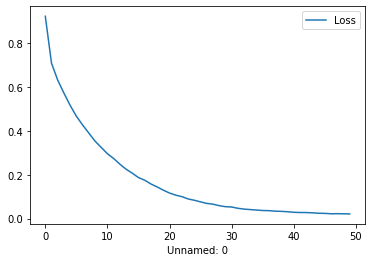

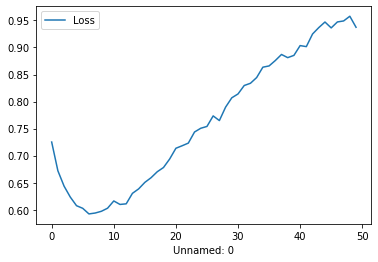

In [ ]:
# Plot the loss
train_loss = pd.read_csv(file_path+"outputs/"+"train_loss.csv", sep="=")
train_loss.plot(0,2)
val_loss = pd.read_csv(file_path+"outputs/"+"val_loss.csv", sep="=")
val_loss.plot(0,2)


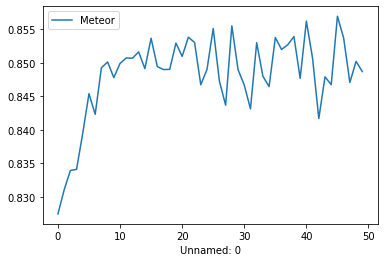

In [ ]:
# Plot the Meteor score
meteor_score = pd.read_csv(file_path+"outputs/"+"meteor.csv", sep="=")
meteor_score.plot(0,2)


### Load and test model

In [ ]:
# Load model and tokenizer
# model_dir = "/content/drive/MyDrive/MRP Idiom Translation/outputs/id_par prefix + idiom/model 2: 50 epochs, batch 4, split 1/"

model_dir = "/content/drive/MyDrive/Pipeline/Data/Idpar_Idiom_IOBs/"

tokenizer = T5Tokenizer.from_pretrained(model_dir+"outputs/model_files")
model = T5ForConditionalGeneration.from_pretrained(model_dir+"outputs/model_files")
model = model.to(device)

In [ ]:
# Prepare test data
test_set = DataSet(
    test_data,
    tokenizer,
    101,
    101,
    "input",
    "target",
)

test_params = {
    "batch_size": 4,
    "shuffle": False,
    "num_workers": 0,
}

test_loader = DataLoader(test_set, **test_params)


In [ ]:
# Run model on test data"
predictions, actuals = validate(0, tokenizer, model, device, test_loader, model_dir+"outputs/test_data/", evaluate=True)

# Evaluate results (only Meteor, for the rest use "Evaluate" notebook)
meteor_test = meteor.compute(predictions=predictions, references=actuals)
print(meteor_test)


{'meteor': 0.8498779657721359}


In [ ]:
# Load predictions.csv to pd dataframe
# Combine columns of validation data IOBs with columns

df = pd.read_csv(model_dir+ "/outputs/test_data/predictions.csv")

df = df.join(test_data["IOB_input"])   #might need to change this depending on the column name 
df = df.join(test_data["IOB_target"])  #might need to change this depending on the column name

output_dir = model_dir+"outputs/test_data/"
df.to_csv(os.path.join(output_dir, "predictions_IOBs.csv"))